# Prédiction des Rendements ETF avec Machine Learning

Ce notebook prédit les rendements futurs de 12 ETFs et construit un portefeuille optimisé.

## Étapes du projet

1. Téléchargement des données historiques
2. Création des features (indicateurs techniques)
3. Préparation des données pour le ML
4. Entraînement de modèles de prédiction
5. Construction d'un portefeuille optimisé


In [41]:
import yfinance as yf
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

## 1. Téléchargement des Données

On récupère les prix historiques de 12 ETFs depuis 2015.

Ces ETFs couvrent différents secteurs (tech, énergie, matières premières, etc.).


In [42]:
tickers = ["PSI", "IYW", "RING", "PICK", "NLR", "UTES", "LIT", "NANR", "GUNR", "XCEM", "PTLC", "FXU"]
start_date = "2010-01-01"

data = yf.download(tickers=tickers, start=start_date, auto_adjust=True, progress=False)

In [43]:
close_prices = data["Close"].dropna()

In [44]:
close_prices

Ticker,FXU,GUNR,IYW,LIT,NANR,NLR,PICK,PSI,PTLC,RING,UTES,XCEM
Date,,,,,,,,,,,,
2015-12-18,16.569330,15.826993,24.743822,16.902910,19.121029,33.434586,10.725579,8.048888,20.466747,9.423354,21.083979,14.977439
2015-12-21,16.682301,15.882772,24.977724,16.920219,18.894260,33.416504,10.887068,8.157701,20.620087,9.601747,20.755665,14.329369
2015-12-22,16.817873,16.105886,25.134436,17.266413,19.259869,33.853428,11.169676,8.186505,20.746367,9.636726,20.859764,14.449601
2015-12-23,17.178965,16.682365,25.335579,17.560677,20.045076,34.184879,11.506113,8.231308,21.025993,9.846600,21.235315,14.449601
2015-12-24,17.163734,16.667791,25.315876,17.482786,20.099068,34.440998,11.721433,8.295315,21.025993,10.056475,21.212101,14.728184
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-12,45.080002,47.810001,202.419998,70.000000,72.570000,143.059998,55.590000,89.099998,56.660000,82.339996,78.839996,40.259998
2026-01-13,45.389999,48.299999,201.899994,70.510002,73.370003,140.839996,55.660000,89.660004,56.564999,83.010002,79.529999,40.040001
2026-01-14,45.849998,49.250000,199.259995,70.620003,74.820000,144.470001,56.990002,89.550003,56.279999,83.330002,79.849998,40.310001


## 2. Création des Features

On calcule des indicateurs techniques pour chaque ETF.

**Momentum** : performance passée (1, 3, 6 mois)

**Volatilité** : mesure du risque

**Max Drawdown** : perte maximale sur 6 mois

**Corrélation** : co-mouvement avec les autres ETFs

**Target** : rendement sur 22 jours (notre objectif de prédiction)


In [45]:
returns = close_prices.pct_change().dropna()

momentum_1m = close_prices.pct_change(21)
momentum_3m = close_prices.pct_change(63)
momentum_6m = close_prices.pct_change(126)

vol_1m = returns.rolling(21).std()
vol_3m = returns.rolling(63).std()

# CORRECTION: Return FUTUR sur 22 jours (shift négatif pour regarder vers le futur)
return_22d = close_prices.pct_change(22).shift(-22)


In [46]:
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

drawdown_6m = returns.rolling(126).apply(max_drawdown, raw=False)

def compute_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

rsi_14 = compute_rsi(close_prices, 14)

# Position dans le range 52 semaines (0 = plus bas, 1 = plus haut)
high_52w = close_prices.rolling(252).max()
low_52w = close_prices.rolling(252).min()
position_52w = (close_prices - low_52w) / (high_52w - low_52w + 1e-8)


In [47]:
corr_3m = returns.rolling(63).corr().groupby(level=0).mean()
corr_6m = returns.rolling(126).corr().groupby(level=0).mean()

In [48]:
features = pd.concat({
    "return_22d": return_22d,
    "momentum_1m": momentum_1m,
    "momentum_3m": momentum_3m,
    "momentum_6m": momentum_6m,
    "vol_1m": vol_1m,
    "vol_3m": vol_3m,
    "max_dd_6m": drawdown_6m,
    "corr_3m": corr_3m,
    "corr_6m": corr_6m,
    "rsi_14": rsi_14,
    "position_52w": position_52w
}, axis=1).dropna()

features

return_22d                                                    \
Ticker            FXU      GUNR       IYW       LIT      NANR       NLR   
Date                                                                      
2016-12-16   0.009355  0.045654  0.023991  0.085417  0.042431  0.012647   
2016-12-19   0.002649  0.061141  0.017214  0.082087  0.052647  0.000209   
2016-12-20   0.001155  0.071672  0.026154  0.101174  0.065944 -0.003553   
2016-12-21   0.005236  0.075983  0.039513  0.115216  0.067290 -0.001888   
2016-12-22   0.007454  0.065164  0.043051  0.120843  0.054381 -0.003353   
...               ...       ...       ...       ...       ...       ...   
2025-12-09   0.011062  0.071899 -0.008828  0.092963  0.097031  0.087808   
2025-12-10   0.020286  0.071671 -0.013451  0.084046  0.091842  0.077483   
2025-12-11   0.026048  0.080138 -0.021139  0.087237  0.097898  0.071890   
2025-12-12   0.034853  0.087153  0.007182  0.112454  0.104012  0.145588   
2025-12-15   0.031500  0.083860  0.016657  0.098085  0.105892  0.203496   

                                                                        \
Ticker          PICK       PSI      PTLC      RING      UTES      XCEM   
Date                                                                     
2016-12-16  0.089583  0.027065  0.006119  0.221651  0.012388  0.052961   
2016-12-19  0.121414  0.011580  0.004046  0.250866  0.005857  0.070040   
2016-12-20  0.145634  0.026776  0.005318  0.251995  0.001896  0.086527   
2016-12-21  0.154319  0.040655  0.015337  0.242931  0.002033  0.094379   
2016-12-22  0.155642  0.030682  0.017013  0.201018  0.006100  0.095636   
...              ...       ...       ...       ...       ...       ...   
2025-12-09  0.159089  0.085198  0.019897  0.179711  0.004575  0.084878   
2025-12-10  0.134469  0.063902  0.011341  0.175239  0.009655  0.067163   
2025-12-11  0.148899  0.065758  0.004291  0.135471 -0.003402  0.081605   
2025-12-12  0.165546  0.150166  0.017573  0.149572  0.043805  0.100930   
2025-12-15  0.147752  0.165271  0.017760  0.147523  0.004327  0.103411   

           momentum_1m                                                    \
Ticker             FXU      GUNR       IYW       LIT      NANR       NLR   
Date                                                                       
2016-12-16    0.060165  0.035056  0.029156  0.055015  0.026102  0.065798   
2016-12-19    0.064858  0.028954  0.030662  0.056794  0.032464  0.068729   
2016-12-20    0.064465  0.038867  0.033975  0.056636  0.032822  0.079390   
2016-12-21    0.046536  0.020365  0.022620  0.046541  0.007809  0.062364   
2016-12-22    0.046812  0.003975  0.016588  0.031640  0.002501  0.061202   
...                ...       ...       ...       ...       ...       ...   
2025-12-09   -0.037077  0.030985  0.023755  0.054689  0.056590 -0.014909   
2025-12-10   -0.039220  0.024374 -0.000683  0.046198  0.052224 -0.040673   
2025-12-11   -0.038232  0.027753  0.001328  0.054225  0.055293  0.012757   
2025-12-12   -0.039511  0.018283 -0.023367  0.025036  0.041597 -0.050688   
2025-12-15   -0.025589  0.021998 -0.007269 -0.001256  0.047602 -0.026699   

                                                                        \
Ticker          PICK       PSI      PTLC      RING      UTES      XCEM   
Date                                                                     
2016-12-16  0.026828  0.048848  0.039367 -0.138176  0.035552  0.008036   
2016-12-19  0.004633  0.044695  0.037321 -0.110302  0.043355 -0.000356   
2016-12-20  0.039447  0.049386  0.044017 -0.102202  0.048496  0.004908   
2016-12-21  0.010593  0.043967  0.033475 -0.120970  0.036712  0.001556   
2016-12-22 -0.043469  0.035298  0.028245 -0.112425  0.027505 -0.011491   
...              ...       ...       ...       ...       ...       ...   
2025-12-09  0.073601  0.073614  0.017766  0.132526 -0.056459  0.012823   
2025-12-10  0.079255  0.066026  0.009286  0.092140 -0.052424  0.005701   
2025-12-11  0.090929  0.091299  0.009088  0.

In [49]:
features.columns = [f"{feat}_{ticker}" for feat, ticker in features.columns]

### Ajout des métadonnées

On ajoute la région géographique de chaque ETF.

Cela donne plus de contexte au modèle.


In [50]:
features = features.reset_index()
dataset = features.melt(id_vars="Date", var_name="Ticker_Feature", value_name="value")
dataset[["Feature", "Ticker"]] = dataset["Ticker_Feature"].str.rsplit("_", n=1, expand=True)
dataset = dataset.pivot_table(index=["Date", "Ticker"], columns="Feature", values="value").reset_index()

In [51]:
dataset = dataset.dropna().reset_index(drop=True)

In [52]:
dataset.head(20)

Feature,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,position_52w,return_22d,rsi_14,vol_1m,vol_3m
0,2016-12-16,FXU,0.504582,0.530281,-0.089893,0.060165,0.032093,0.045887,0.915151,0.009355,57.742034,0.010507,0.009941
1,2016-12-16,GUNR,0.533699,0.617726,-0.071616,0.035056,0.091463,0.104750,0.905437,0.045654,54.754203,0.009222,0.009767
2,2016-12-16,IYW,0.500936,0.579356,-0.066741,0.029156,0.037881,0.159938,0.968373,0.023991,56.034505,0.009077,0.008508
3,2016-12-16,LIT,0.492880,0.580702,-0.101483,0.055015,0.019215,-0.005981,0.899297,0.085417,61.403607,0.009043,0.010524
4,2016-12-16,NANR,0.469991,0.549436,-0.087067,0.026102,0.055376,0.030372,0.920332,0.042431,55.159492,0.011402,0.012292
5,2016-12-16,NLR,0.459158,0.497563,-0.095652,0.065798,0.007389,0.014469,0.803872,0.012647,62.012964,0.011359,0.010594
6,2016-12-16,PICK,0.406195,0.550622,-0.113027,0.026828,0.222685,0.310015,0.845788,0.089583,39.353655,0.017770,0.015430
7,2016-12-16,PSI,0.404739,0.501227,-0.096561,0.048848,0.133720,0.337057,0.970716,0.027065,52.371537,0.016504,0.013119
8,2016-12-16,PTLC,0.518827,0.610997,-0.053006,0.039367,0.061626,0.096614,0.955837,0.006119,72.855283,0.004772,0.005730
9,2016-12-16,RING,0.407989,0.302438,-0.406767,-0.138176,-0.278133,-0.278977,0.334842,0.221651,27.966132,0.026704,0.029872


In [53]:
metadata = pd.read_excel("/Users/hakimbenkirane/Downloads/etf_portfolio_db.xlsx", sheet_name="Qualified_ETFs")

In [54]:
dataset_merged = dataset.merge(metadata[["Ticker", "Region (General)_x"]], on="Ticker", how="left")

In [55]:
dataset_merged.head(10)

,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,position_52w,return_22d,rsi_14,vol_1m,vol_3m,Region (General)_x
0,2016-12-16,FXU,0.504582,0.530281,-0.089893,0.060165,0.032093,0.045887,0.915151,0.009355,57.742034,0.010507,0.009941,North America
1,2016-12-16,GUNR,0.533699,0.617726,-0.071616,0.035056,0.091463,0.104750,0.905437,0.045654,54.754203,0.009222,0.009767,Developed Markets
2,2016-12-16,IYW,0.500936,0.579356,-0.066741,0.029156,0.037881,0.159938,0.968373,0.023991,56.034505,0.009077,0.008508,North America
3,2016-12-16,LIT,0.492880,0.580702,-0.101483,0.055015,0.019215,-0.005981,0.899297,0.085417,61.403607,0.009043,0.010524,Developed Markets
4,2016-12-16,NANR,0.469991,0.549436,-0.087067,0.026102,0.055376,0.030372,0.920332,0.042431,55.159492,0.011402,0.012292,North America
5,2016-12-16,NLR,0.459158,0.497563,-0.095652,0.065798,0.007389,0.014469,0.803872,0.012647,62.012964,0.011359,0.010594,Developed Markets
6,2016-12-16,PICK,0.406195,0.550622,-0.113027,0.026828,0.222685,0.310015,0.845788,0.089583,39.353655,0.017770,0.015430,Developed Markets
7,2016-12-16,PSI,0.404739,0.501227,-0.096561,0.048848,0.133720,0.337057,0.970716,0.027065,52.371537,0.016504,0.013119,North America
8,2016-12-16,PTLC,0.518827,0.610997,-0.053006,0.039367,0.061626,0.096614,0.955837,0.006119,72.855283,0.004772,0.005730,North America
9,2016-12-16,RING,0.407989,0.302438,-0.406767,-0.138176,-0.278133,-0.278977,0.334842,0.221651,27.966132,0.026704,0.029872,Developed Markets


In [94]:
dataset_merged.to_csv("etf_features_dataset_merged.csv", index=False)

## 3. Vérification de la Qualité des Données

On vérifie qu'il n'y a pas de problèmes dans les données :

- Pas de doublons
- Pas de valeurs manquantes
- Dates continues sans gaps


In [56]:
df = dataset_merged
df.shape

(27132, 14)

In [57]:
df.duplicated(subset=["Date", "Ticker"]).sum()

0

In [58]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dtypes

Date                  datetime64[ns]
Ticker                        object
corr_3m                      float64
corr_6m                      float64
max_dd_6m                    float64
momentum_1m                  float64
momentum_3m                  float64
momentum_6m                  float64
position_52w                 float64
return_22d                   float64
rsi_14                       float64
vol_1m                       float64
vol_3m                       float64
Region (General)_x            object
dtype: object

In [59]:
df.isna().mean().sort_values(ascending=False)

Date                  0.0
Ticker                0.0
corr_3m               0.0
corr_6m               0.0
max_dd_6m             0.0
momentum_1m           0.0
momentum_3m           0.0
momentum_6m           0.0
position_52w          0.0
return_22d            0.0
rsi_14                0.0
vol_1m                0.0
vol_3m                0.0
Region (General)_x    0.0
dtype: float64

In [60]:
df.groupby("Ticker")["Date"].apply(lambda x: x.duplicated().sum())

Ticker
FXU     0
GUNR    0
IYW     0
LIT     0
NANR    0
NLR     0
PICK    0
PSI     0
PTLC    0
RING    0
UTES    0
XCEM    0
Name: Date, dtype: int64

In [61]:
def count_date_gaps(x):
    dates = x.sort_values()
    diffs = dates.diff().dt.days
    return (diffs > 5).sum()

df.groupby("Ticker")["Date"].apply(count_date_gaps).sort_values(ascending=False)

Ticker
FXU     0
GUNR    0
IYW     0
LIT     0
NANR    0
NLR     0
PICK    0
PSI     0
PTLC    0
RING    0
UTES    0
XCEM    0
Name: Date, dtype: int64

In [62]:
df.groupby("Ticker")["Date"].nunique().sort_values()

Ticker
FXU     2261
GUNR    2261
IYW     2261
LIT     2261
NANR    2261
NLR     2261
PICK    2261
PSI     2261
PTLC    2261
RING    2261
UTES    2261
XCEM    2261
Name: Date, dtype: int64

## 4. Preprocessing

### Normalisation des features

On utilise RobustScaler pour mettre toutes les features à la même échelle.

Cela améliore la performance du modèle.

La région géographique est encodée en nombre (0, 1, 2).


In [63]:
df

,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,position_52w,return_22d,rsi_14,vol_1m,vol_3m,Region (General)_x
0,2016-12-16,FXU,0.504582,0.530281,-0.089893,0.060165,0.032093,0.045887,0.915151,0.009355,57.742034,0.010507,0.009941,North America
1,2016-12-16,GUNR,0.533699,0.617726,-0.071616,0.035056,0.091463,0.104750,0.905437,0.045654,54.754203,0.009222,0.009767,Developed Markets
2,2016-12-16,IYW,0.500936,0.579356,-0.066741,0.029156,0.037881,0.159938,0.968373,0.023991,56.034505,0.009077,0.008508,North America
3,2016-12-16,LIT,0.492880,0.580702,-0.101483,0.055015,0.019215,-0.005981,0.899297,0.085417,61.403607,0.009043,0.010524,Developed Markets
4,2016-12-16,NANR,0.469991,0.549436,-0.087067,0.026102,0.055376,0.030372,0.920332,0.042431,55.159492,0.011402,0.012292,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27127,2025-12-15,PSI,0.641895,0.552707,-0.130407,0.066327,0.163378,0.406946,0.892079,0.165271,67.215027,0.024132,0.024533,North America
27128,2025-12-15,PTLC,0.650424,0.585034,-0.050801,0.013126,0.033426,0.134401,0.927253,0.017760,65.137523,0.007387,0.007767,North America
27129,2025-12-15,RING,0.551991,0.455404,-0.192212,0.102164,0.237804,0.625809,0.979342,0.147523,71.457116,0.023843,0.029266,Developed Markets
27130,2025-12-15,UTES,0.577581,0.436106,-0.098720,-0.014731,-0.015618,0.085912,0.719126,0.004327,38.271583,0.012653,0.012058,North America


In [64]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

# CORRECTION: Normalisation SANS leakage
# On va d'abord créer df1 sans normaliser, puis normaliser APRÈS le split

df1 = df.copy()

# Encoder la région maintenant (pas de leakage ici)
le = LabelEncoder()
df1['Region_Encoded'] = le.fit_transform(df1['Region (General)_x'])

print(f"\nEncoding:")
for i, region in enumerate(le.classes_):
    print(f"  {region} -> {i}")

# NOTE: La normalisation sera faite APRÈS le split temporel pour éviter le data leakage

df1.head(10)


Encoding:
  Developed Markets -> 0
  Emerging Markets -> 1
  North America -> 2


,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,position_52w,return_22d,rsi_14,vol_1m,vol_3m,Region (General)_x,Region_Encoded
0,2016-12-16,FXU,0.504582,0.530281,-0.089893,0.060165,0.032093,0.045887,0.915151,0.009355,57.742034,0.010507,0.009941,North America,2
1,2016-12-16,GUNR,0.533699,0.617726,-0.071616,0.035056,0.091463,0.104750,0.905437,0.045654,54.754203,0.009222,0.009767,Developed Markets,0
2,2016-12-16,IYW,0.500936,0.579356,-0.066741,0.029156,0.037881,0.159938,0.968373,0.023991,56.034505,0.009077,0.008508,North America,2
3,2016-12-16,LIT,0.492880,0.580702,-0.101483,0.055015,0.019215,-0.005981,0.899297,0.085417,61.403607,0.009043,0.010524,Developed Markets,0
4,2016-12-16,NANR,0.469991,0.549436,-0.087067,0.026102,0.055376,0.030372,0.920332,0.042431,55.159492,0.011402,0.012292,North America,2
5,2016-12-16,NLR,0.459158,0.497563,-0.095652,0.065798,0.007389,0.014469,0.803872,0.012647,62.012964,0.011359,0.010594,Developed Markets,0
6,2016-12-16,PICK,0.406195,0.550622,-0.113027,0.026828,0.222685,0.310015,0.845788,0.089583,39.353655,0.017770,0.015430,Developed Markets,0
7,2016-12-16,PSI,0.404739,0.501227,-0.096561,0.048848,0.133720,0.337057,0.970716,0.027065,52.371537,0.016504,0.013119,North America,2
8,2016-12-16,PTLC,0.518827,0.610997,-0.053006,0.039367,0.061626,0.096614,0.955837,0.006119,72.855283,0.004772,0.005730,North America,2
9,2016-12-16,RING,0.407989,0.302438,-0.406767,-0.138176,-0.278133,-0.278977,0.334842,0.221651,27.966132,0.026704,0.029872,Developed Markets,0


### Analyse de corrélation

On visualise les corrélations entre features.

Si deux features sont très corrélées (>0.7), on peut en retirer une.


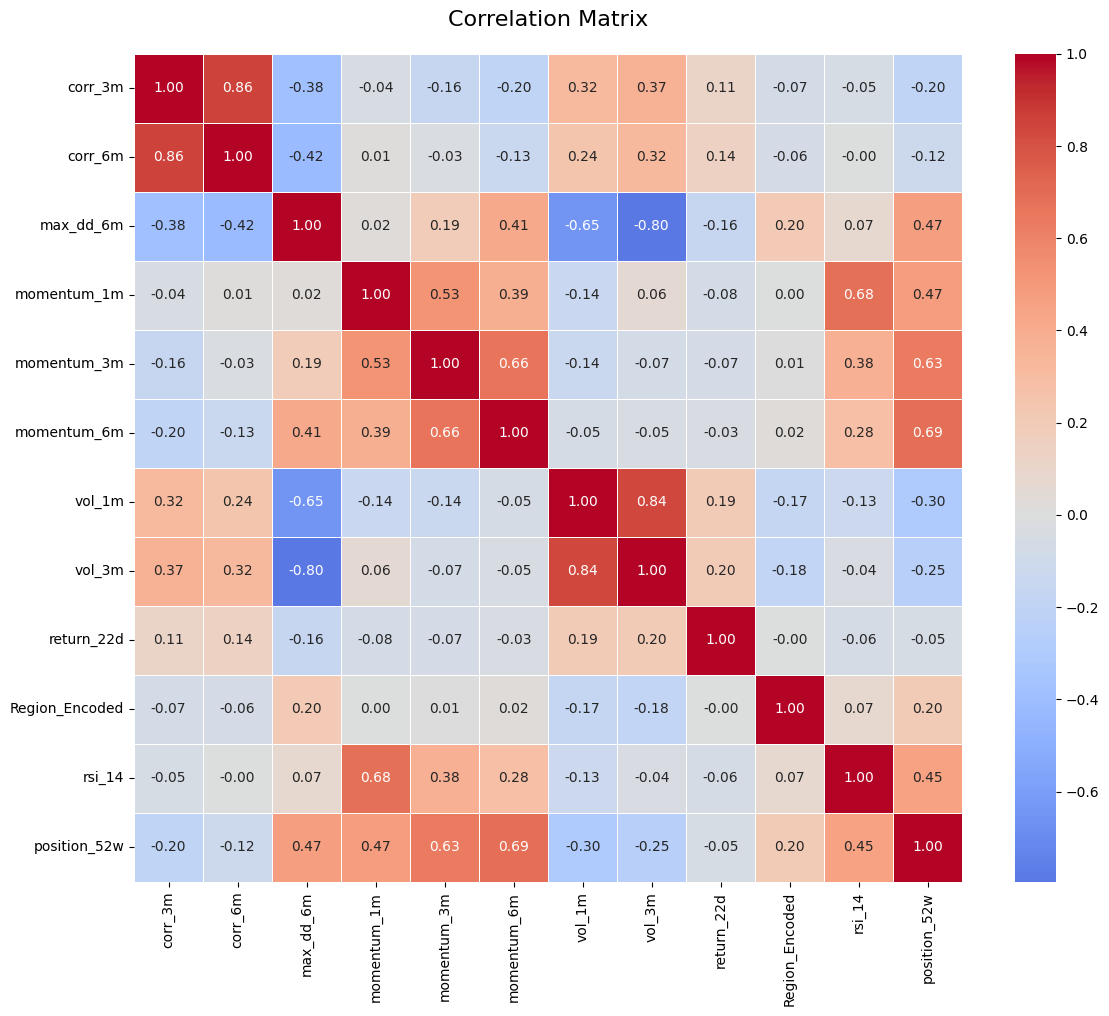

Corrélations élevées (|r| > 0.7):
Feature 1 Feature 2  Correlation
  corr_3m   corr_6m     0.856098
   vol_1m    vol_3m     0.837468
max_dd_6m    vol_3m    -0.795880


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# CORRECTION: Analyse de corrélation sans normalisation préalable
numeric_cols = ['corr_3m', 'corr_6m', 'max_dd_6m', 'momentum_1m', 'momentum_3m', 'momentum_6m', 'vol_1m', 'vol_3m', 'return_22d', 'Region_Encoded', 'rsi_14', 'position_52w']
correlation_matrix = df1[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr:
    print("Corrélations élevées (|r| > 0.7):")
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("Aucune corrélation élevée trouvée")

On retire les features trop corrélées pour éviter la redondance.


In [66]:
df1.drop(columns=["vol_3m","corr_6m", "Region (General)_x"], inplace=True)

In [67]:
df1.set_index(['Date', 'Ticker'], inplace=True)

In [68]:
df1

corr_3m  max_dd_6m  momentum_1m  momentum_3m  momentum_6m  \
Date       Ticker                                                               
2016-12-16 FXU     0.504582  -0.089893     0.060165     0.032093     0.045887   
           GUNR    0.533699  -0.071616     0.035056     0.091463     0.104750   
           IYW     0.500936  -0.066741     0.029156     0.037881     0.159938   
           LIT     0.492880  -0.101483     0.055015     0.019215    -0.005981   
           NANR    0.469991  -0.087067     0.026102     0.055376     0.030372   
...                     ...        ...          ...          ...          ...   
2025-12-15 PSI     0.641895  -0.130407     0.066327     0.163378     0.406946   
           PTLC    0.650424  -0.050801     0.013126     0.033426     0.134401   
           RING    0.551991  -0.192212     0.102164     0.237804     0.625809   
           UTES    0.577581  -0.098720    -0.014731    -0.015618     0.085912   
           XCEM    0.641029  -0.048218    -0.000525     0.048196     0.147769   

                   position_52w  return_22d     rsi_14    vol_1m  \
Date       Ticker                                                  
2016-12-16 FXU         0.915151    0.009355  57.742034  0.010507   
           GUNR        0.905437    0.045654  54.754203  0.009222   
           IYW         0.968373    0.023991  56.034505  0.009077   
           LIT         0.899297    0.085417  61.403607  0.009043   
           NANR        0.920332    0.042431  55.159492  0.011402   
...                         ...         ...        ...       ...   
2025-12-15 PSI         0.892079    0.165271  67.215027  0.024132   
           PTLC        0.927253    0.017760  65.137523  0.007387   
           RING        0.979342    0.147523  71.457116  0.023843   
           UTES        0.719126    0.004327  38.271583  0.012653   
           XCEM        0.924452    0.103411  63.042764  0.006740   

                   Region_Encoded  
Date       Ticker                  
2016-12-16 FXU                  2  
           GUNR                 0  
           IYW                  2  
           LIT                  0  
           NANR                 2  
...                           ...  
2025-12-15 PSI                  2  
           PTLC                 2  
           RING                 0  
           UTES                 2  
           XCEM                 1  

[27132 rows x 10 columns]

## 5. Entraînement des Modèles

On va entraîner deux modèles pour prédire les rendements à 22 jours.


In [69]:
import tensorflow as tf
from tf_keras.models import Sequential
from tf_keras.layers import LSTM, Dense, Dropout
from tf_keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tf_keras.optimizers import Adam

### Préparation des séquences

On crée des séquences de 10 jours consécutifs.

Le modèle regarde 10 jours d'historique pour prédire le rendement futur.


In [70]:
# CORRECTION: Préparer df_model SANS normalisation (on normalisera après le split)
df_model = df1.reset_index()
df_model = df_model.sort_values(['Ticker', 'Date'])
df_model

,Date,Ticker,corr_3m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,position_52w,return_22d,rsi_14,vol_1m,Region_Encoded
0,2016-12-16,FXU,0.504582,-0.089893,0.060165,0.032093,0.045887,0.915151,0.009355,57.742034,0.010507,2
12,2016-12-19,FXU,0.505494,-0.089893,0.064858,0.045825,0.042145,0.935088,0.002649,59.813092,0.010500,2
24,2016-12-20,FXU,0.480396,-0.089893,0.064465,0.026146,0.046643,0.933554,0.001155,77.108600,0.010506,2
36,2016-12-21,FXU,0.476102,-0.089893,0.046536,0.011625,0.034823,0.919777,0.005236,80.340271,0.010293,2
48,2016-12-22,FXU,0.476702,-0.089893,0.046812,0.015411,0.049505,0.933710,0.007454,79.124782,0.010294,2
...,...,...,...,...,...,...,...,...,...,...,...,...
27083,2025-12-09,XCEM,0.642989,-0.048218,0.012823,0.080991,0.158998,0.950934,0.084878,66.325675,0.007464,1
27095,2025-12-10,XCEM,0.641759,-0.048218,0.005701,0.084381,0.167569,0.985378,0.067163,72.794198,0.006751,1
27107,2025-12-11,XCEM,0.627977,-0.048218,-0.003516,0.076214,0.157310,0.964256,0.081605,76.447848,0.006897,1
27119,2025-12-12,XCEM,0.633500,-0.048218,-0.013727,0.054848,0.160622,0.926076,0.100930,66.220830,0.007377,1


In [71]:
def create_sequences_with_info(data, seq_length=10):
    X, y = [], []
    info = []

    for ticker in data['Ticker'].unique():
        ticker_data = data[data['Ticker'] == ticker].sort_values('Date')
        features = ticker_data[['corr_3m', 'max_dd_6m', 'momentum_1m',
                                'momentum_3m', 'momentum_6m', 'vol_1m',
                                'Region_Encoded', 'rsi_14', 'position_52w']].values
        target = ticker_data['return_22d'].values
        dates = ticker_data['Date'].values

        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            y.append(target[i+seq_length])
            info.append({'ticker': ticker, 'date': dates[i+seq_length]})

    return np.array(X), np.array(y), pd.DataFrame(info)

In [72]:
# CORRECTION: Split temporel global par date de coupure unique
train_cutoff = pd.Timestamp('2024-01-01')
val_cutoff = pd.Timestamp('2024-07-01')

# Créer les séquences pour TOUTES les données
X_all, y_all, info_all = create_sequences_with_info(df_model.reset_index(drop=True), seq_length=10)

# Convertir info_all['date'] en datetime
info_all['date'] = pd.to_datetime(info_all['date'])

# Split basé sur la date
train_mask = info_all['date'] < train_cutoff
val_mask = (info_all['date'] >= train_cutoff) & (info_all['date'] < val_cutoff)
test_mask = info_all['date'] >= val_cutoff

X_train_final = X_all[train_mask]
y_train_final = y_all[train_mask]
info_train_final = info_all[train_mask].reset_index(drop=True)

X_val = X_all[val_mask]
y_val = y_all[val_mask]
info_val = info_all[val_mask].reset_index(drop=True)

X_test = X_all[test_mask]
y_test = y_all[test_mask]
test_info = info_all[test_mask].reset_index(drop=True)

print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTraining set: {len(info_train_final)} échantillons")
print(f"  Date range: {info_train_final['date'].min()} à {info_train_final['date'].max()}")
print(f"\nValidation set: {len(info_val)} échantillons")
print(f"  Date range: {info_val['date'].min()} à {info_val['date'].max()}")
print(f"\nTest set: {len(test_info)} échantillons")
print(f"  Date range: {test_info['date'].min()} à {test_info['date'].max()}")

X_train_final shape: (21120, 10, 9)
X_val shape: (1488, 10, 9)
X_test shape: (4404, 10, 9)

Training set: 21120 échantillons
  Date range: 2017-01-03 00:00:00 à 2023-12-29 00:00:00

Validation set: 1488 échantillons
  Date range: 2024-01-02 00:00:00 à 2024-06-28 00:00:00

Test set: 4404 échantillons
  Date range: 2024-07-01 00:00:00 à 2025-12-15 00:00:00


In [73]:
from sklearn.preprocessing import RobustScaler

# Indices des features numériques (exclure Region_Encoded qui est à l'indice 6)
numeric_features_indices = [0, 1, 2, 3, 4, 5, 7, 8]

# Créer un scaler PAR TICKER
scalers = {}

for ticker in tickers:
    # Masks pour ce ticker
    train_mask = info_train_final['ticker'] == ticker
    val_mask = info_val['ticker'] == ticker
    test_mask = test_info['ticker'] == ticker

    # Créer le scaler pour ce ticker
    scalers[ticker] = RobustScaler()

    # Extraire et reshape les données de ce ticker
    X_train_t = X_train_final[train_mask].reshape(-1, X_train_final.shape[2])
    X_val_t = X_val[val_mask].reshape(-1, X_val.shape[2])
    X_test_t = X_test[test_mask].reshape(-1, X_test.shape[2])

    # Fit sur les données train de CE ticker uniquement
    scalers[ticker].fit(X_train_t[:, numeric_features_indices])

    # Transform train, val, test pour ce ticker
    X_train_t[:, numeric_features_indices] = scalers[ticker].transform(X_train_t[:, numeric_features_indices])
    X_val_t[:, numeric_features_indices] = scalers[ticker].transform(X_val_t[:, numeric_features_indices])
    X_test_t[:, numeric_features_indices] = scalers[ticker].transform(X_test_t[:, numeric_features_indices])

    # Reshape back et réassigner
    X_train_final[train_mask] = X_train_t.reshape(-1, 10, 9)
    X_val[val_mask] = X_val_t.reshape(-1, 10, 9)
    X_test[test_mask] = X_test_t.reshape(-1, 10, 9)

print("Normalisation par ticker terminée")
print(f"Scalers créés pour : {list(scalers.keys())}")

Normalisation par ticker terminée
Scalers créés pour : ['PSI', 'IYW', 'RING', 'PICK', 'NLR', 'UTES', 'LIT', 'NANR', 'GUNR', 'XCEM', 'PTLC', 'FXU']


In [74]:
# Compter par split
for name, info in [("TRAIN Split", info_train_final), ("VAL Split", info_val), ("TEST Split", test_info)]:
    print(f"\n{name}:")
    print(info['ticker'].value_counts().sort_index())


TRAIN Split:
ticker
FXU     1760
GUNR    1760
IYW     1760
LIT     1760
NANR    1760
NLR     1760
PICK    1760
PSI     1760
PTLC    1760
RING    1760
UTES    1760
XCEM    1760
Name: count, dtype: int64

VAL Split:
ticker
FXU     124
GUNR    124
IYW     124
LIT     124
NANR    124
NLR     124
PICK    124
PSI     124
PTLC    124
RING    124
UTES    124
XCEM    124
Name: count, dtype: int64

TEST Split:
ticker
FXU     367
GUNR    367
IYW     367
LIT     367
NANR    367
NLR     367
PICK    367
PSI     367
PTLC    367
RING    367
UTES    367
XCEM    367
Name: count, dtype: int64


### Entraînement des modèles LSTM (1 par ticker)

Les LSTM sont faits pour les séries temporelles.

Chaque ticker aura son propre modèle pour capturer ses patterns spécifiques.

In [75]:
def correlation_loss(y_true, y_pred):
    """Loss basée sur la corrélation - encourage les prédictions variées"""
    y_true_centered = y_true - tf.reduce_mean(y_true)
    y_pred_centered = y_pred - tf.reduce_mean(y_pred)

    correlation = tf.reduce_sum(y_true_centered * y_pred_centered) / (
        tf.sqrt(tf.reduce_sum(tf.square(y_true_centered))) *
        tf.sqrt(tf.reduce_sum(tf.square(y_pred_centered))) + 1e-8
    )
    return -correlation  # Négatif car on veut maximiser la corrélation

# Ou combinée avec MSE
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    corr = correlation_loss(y_true, y_pred)
    return mse + 0.1 * corr


In [ ]:
def build_ticker_model():
    model = Sequential([
        LSTM(16, input_shape=(10, 9), 
             kernel_regularizer=l2(0.0001)),
        Dropout(0.2),
        Dense(1, kernel_regularizer=l2(0.0001))
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='huber',  
        metrics=['mae']
    )
    return model

# Callbacks avec patience augmentée
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15,          
        restore_best_weights=True, 
        min_delta=0.0001
    )
]

models = {}
histories = {}

for ticker in tickers:
    print(f"\n=== Training {ticker} ===")
    
    ticker_mask_train = info_train_final['ticker'] == ticker
    ticker_mask_val = info_val['ticker'] == ticker
    
    X_train_t = X_train_final[ticker_mask_train]
    y_train_t = y_train_final[ticker_mask_train]
    X_val_t = X_val[ticker_mask_val]
    y_val_t = y_val[ticker_mask_val]
    
    models[ticker] = build_ticker_model()
    histories[ticker] = models[ticker].fit(
        X_train_t, y_train_t,
        validation_data=(X_val_t, y_val_t),
        epochs=100,           
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    val_loss, val_mae = models[ticker].evaluate(X_val_t, y_val_t, verbose=0)
    train_loss, train_mae = models[ticker].evaluate(X_train_t, y_train_t, verbose=0)

    print(f"{ticker}: Train MAE={train_mae:.4f}, Val MAE={val_mae:.4f}")

In [ ]:
models = {}
histories = {}

for ticker in tickers:
    print(f"\n=== Training {ticker} ===")

    ticker_mask_train = info_train_final['ticker'] == ticker
    ticker_mask_val = info_val['ticker'] == ticker

    X_train_t = X_train_final[ticker_mask_train]
    y_train_t = y_train_final[ticker_mask_train]
    X_val_t = X_val[ticker_mask_val]
    y_val_t = y_val[ticker_mask_val]

    models[ticker] = build_ticker_model(input_shape=(10,9))        #build_ticker_model()
    histories[ticker] = models[ticker].fit(
        X_train_t, y_train_t,
        validation_data=(X_val_t, y_val_t),
        epochs=2000,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
        verbose=0
    )

    val_loss, val_mae = models[ticker].evaluate(X_val_t, y_val_t, verbose=0)
    print(f"{ticker}: Val MAE = {val_mae:.4f}")


=== Training PSI ===
PSI: Val MAE = 0.0520

=== Training IYW ===
IYW: Val MAE = 0.0437

=== Training RING ===
RING: Val MAE = 0.0835

=== Training PICK ===
PICK: Val MAE = 0.0414

=== Training NLR ===
NLR: Val MAE = 0.0489

=== Training UTES ===
UTES: Val MAE = 0.0420

=== Training LIT ===
LIT: Val MAE = 0.0437

=== Training NANR ===
NANR: Val MAE = 0.0510

=== Training GUNR ===
GUNR: Val MAE = 0.0416

=== Training XCEM ===
XCEM: Val MAE = 0.0246

=== Training PTLC ===
PTLC: Val MAE = 0.0208

=== Training FXU ===
FXU: Val MAE = 0.0320


### Visualisation des prédictions par ETF

On compare les prédictions avec la réalité pour chaque ETF.

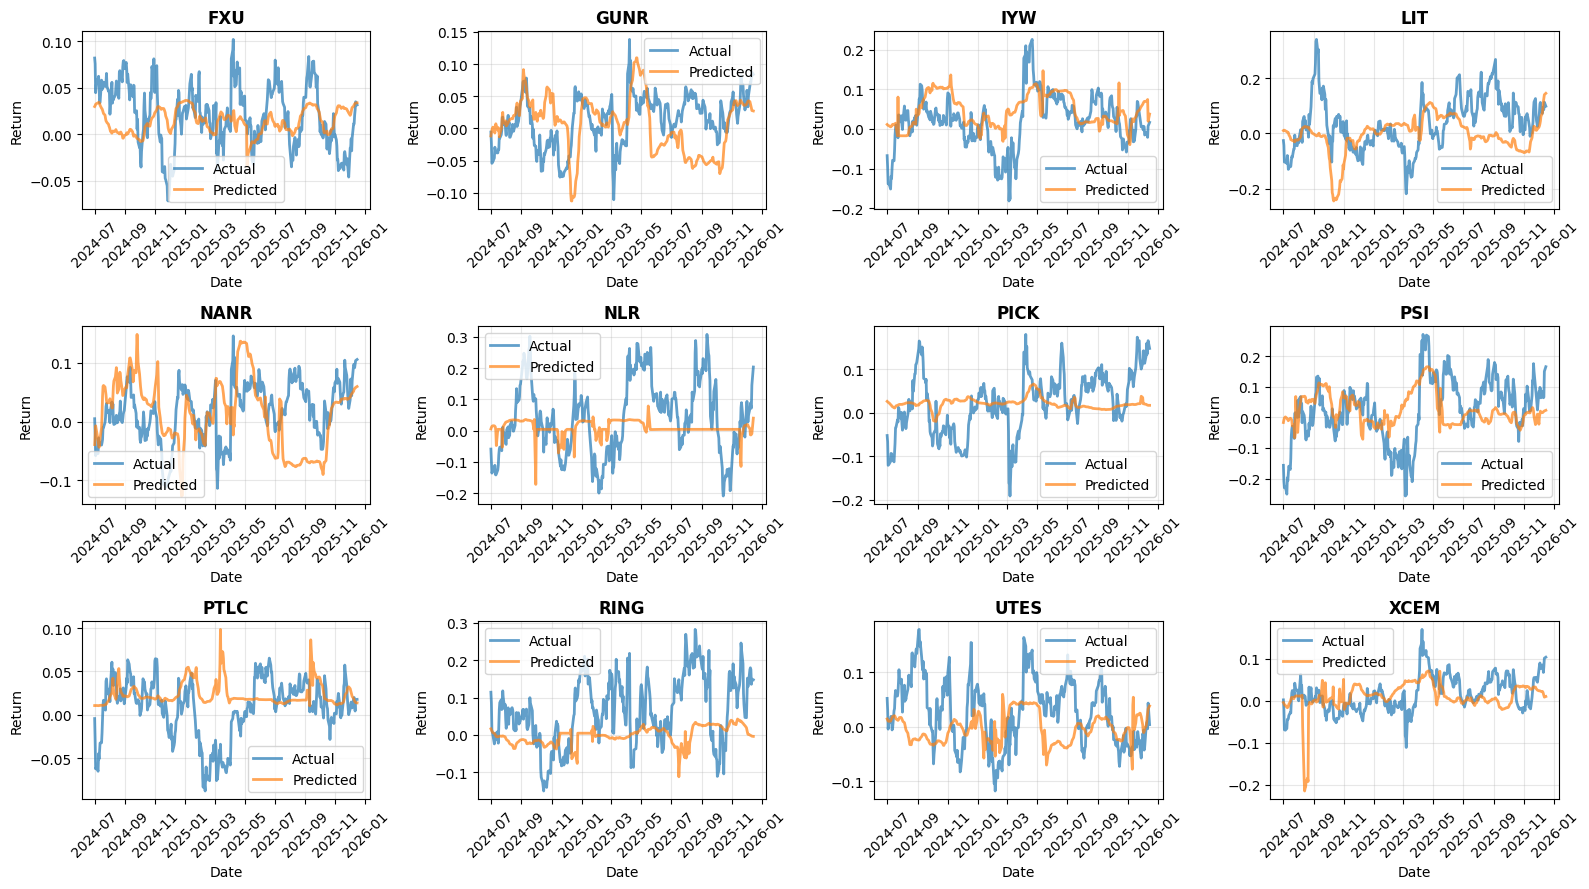

In [100]:
# Prédictions avec un modèle par ticker
test_info['predicted'] = 0.0

for ticker in tickers:
    ticker_mask = test_info['ticker'] == ticker
    X_test_t = X_test[ticker_mask]
    test_info.loc[ticker_mask, 'predicted'] = models[ticker].predict(X_test_t, verbose=0).flatten()

test_info['actual'] = y_test

# Create subplots for each ticker
tickers_list = test_info['ticker'].unique()
n_tickers = len(tickers_list)
n_cols = 4
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(tickers_list)):
    ticker_data = test_info[test_info['ticker'] == ticker].sort_values('date')

    axes[idx].plot(ticker_data['date'], ticker_data['actual'], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(ticker_data['date'], ticker_data['predicted'], label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_title(f'{ticker}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Return')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Hide empty subplots
for idx in range(n_tickers, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

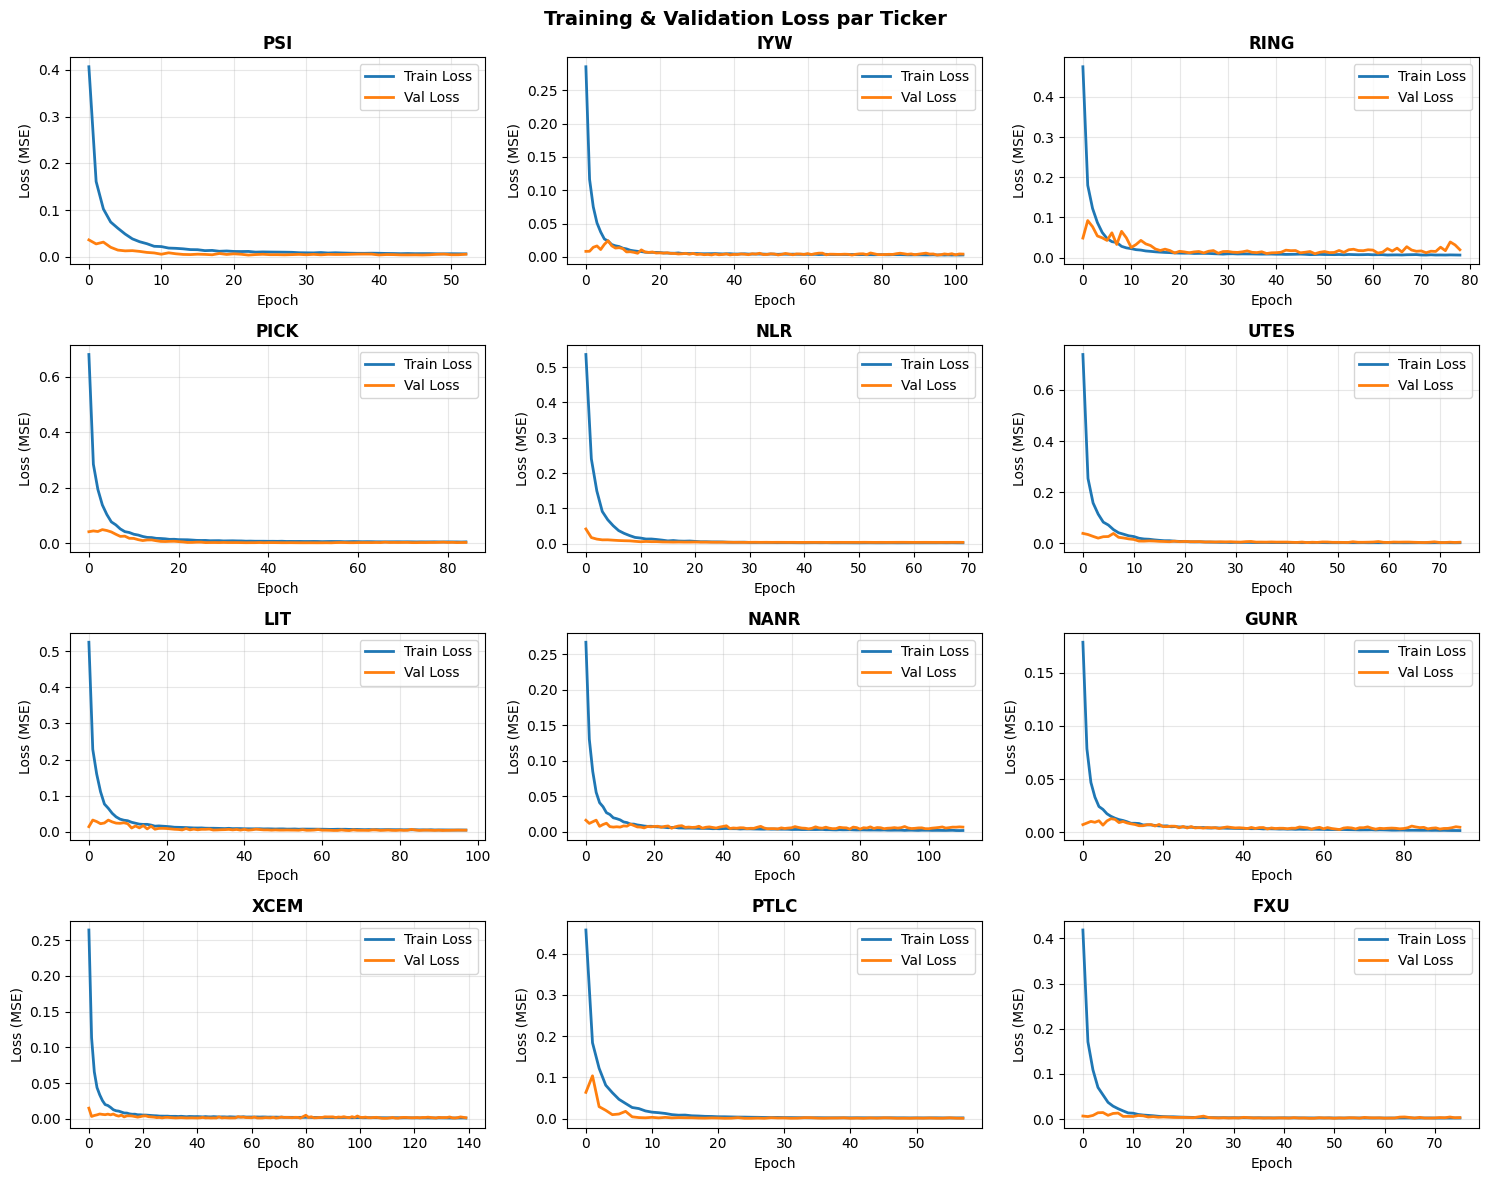

In [101]:
# Visualisation des loss pour chaque modèle
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ax = axes[idx]

    ax.plot(histories[ticker].history['loss'], label='Train Loss', linewidth=2)
    ax.plot(histories[ticker].history['val_loss'], label='Val Loss', linewidth=2)

    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Training & Validation Loss par Ticker', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

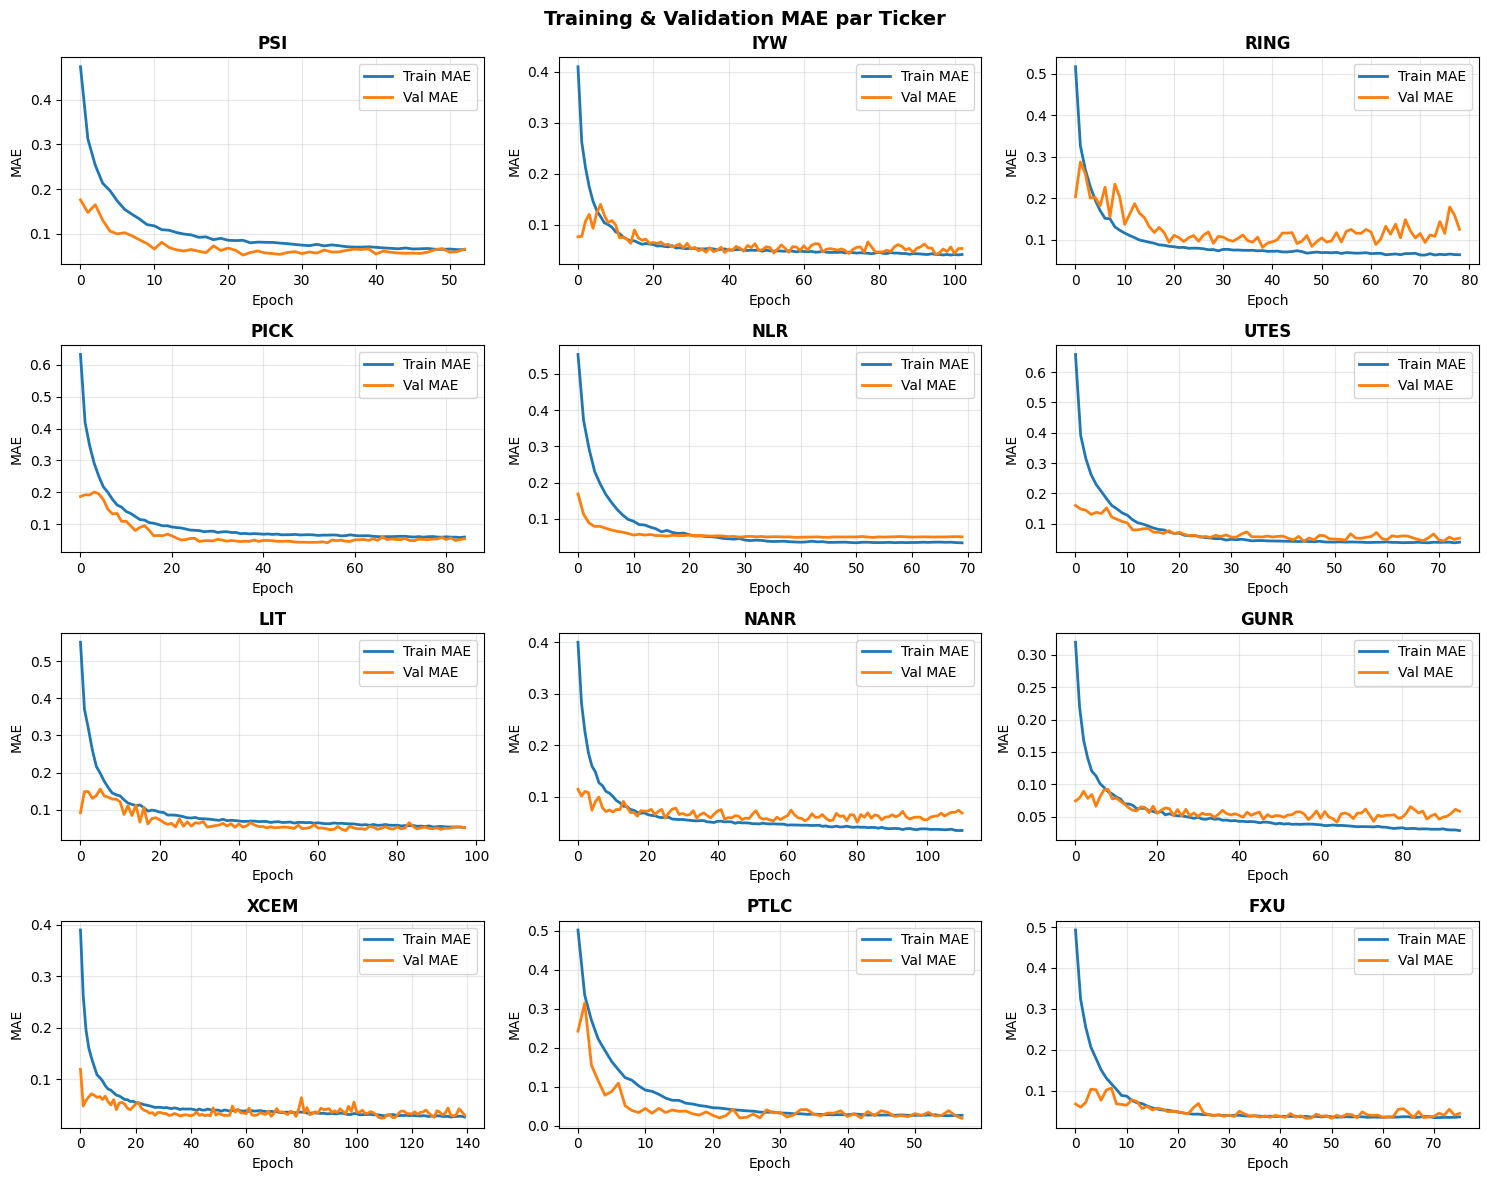

In [102]:
# Visualisation des MAE pour chaque modèle
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ax = axes[idx]

    ax.plot(histories[ticker].history['mae'], label='Train MAE', linewidth=2)
    ax.plot(histories[ticker].history['val_mae'], label='Val MAE', linewidth=2)

    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MAE')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Training & Validation MAE par Ticker', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()